# How to use paramManager
paramManager writes and reads parameter files for data file sets, one structured parameter dictionary per data file.

In [1]:
import numpy as np
import librosa # conda install -c conda-forge librosa
import librosa.display

import os  # for mkdir
from os import listdir
from os.path import isfile, join

%matplotlib inline
import matplotlib.pyplot as plt

##-----------   paramManager  interface   ------------------##
from paramManager import paramManager

In [2]:
datapath='../dataset'
parampath='../dataparam' 
# print the files (but not the directories) in datapath
[f for f in os.listdir(datapath) if os.path.isfile(os.path.join(datapath, f))]

['brass_acoustic_018-052-127.wav',
 'brass_acoustic_018-053-127.wav',
 'brass_acoustic_018-054-127.wav',
 'brass_acoustic_018-055-127.wav',
 'brass_acoustic_018-056-127.wav',
 'brass_acoustic_018-057-127.wav',
 'brass_acoustic_018-058-127.wav',
 'brass_acoustic_018-059-127.wav',
 'brass_acoustic_018-060-127.wav',
 'brass_acoustic_018-061-127.wav',
 'brass_acoustic_018-062-127.wav',
 'brass_acoustic_018-063-127.wav',
 'brass_acoustic_018-064-127.wav',
 'brass_acoustic_018-065-127.wav',
 'brass_acoustic_018-066-127.wav',
 'brass_acoustic_018-067-127.wav',
 'brass_acoustic_018-068-127.wav',
 'brass_acoustic_018-069-127.wav',
 'brass_acoustic_018-070-127.wav',
 'brass_acoustic_018-071-127.wav',
 'brass_acoustic_018-072-127.wav',
 'brass_acoustic_018-073-127.wav',
 'brass_acoustic_018-074-127.wav',
 'brass_acoustic_018-075-127.wav',
 'brass_acoustic_018-076-127.wav',
 'brass_acoustic_018-077-127.wav',
 'brass_acoustic_018-078-127.wav',
 'brass_acoustic_018-079-127.wav',
 'brass_acoustic_018

In [3]:
# paramManager, create 
pm=paramManager(datapath, parampath)  ##-----------   paramManager  interface ------------------##

In [4]:
# initialize parameter files for the data (only necessary if they don't already exist)
# The boolean parameter tells whether to overwrite current parameter directory (default is False)
pm.initParamFiles(overwrite=True) ##-----------   paramManager  interface ------------------##

In [5]:
# paramManager , check that data files and paramfiles match in number and name
pm.checkIntegrity() ##-----------   paramManager  interface   ------------------##

True

In [6]:
# param Manager , get the parameter dictionary for a file 
# This is the critical function for getting parameters for training nets. 

##-----------   paramManager  interface   ------------------##
foo=pm.getParams(datapath + '/' + 'reed_acoustic_000-072-127.wav') #the path and extension are optional
foo

{'meta': {'filename': 'reed_acoustic_000-072-127.wav'}}

# First a little essentia demo

In [ ]:
# http://essentia.upf.edu/documentation/documentation.html
import essentia # conda install -c thomasfillon essentia
import essentia.standard


In [ ]:
testfile = datapath + '/' + 'reed_acoustic_000-072-127.wav'

loader = essentia.standard.AudioLoader(filename=testfile) #Monoloader doesn't get metadata

# and then we actually perform the loading:
(audio, sr,chans,_,_,_) = loader()
print("shape of audio is  is {}".format(audio.shape))
print("chans is {}".format(chans))
print("audio is {}".format(audio))
audio=audio[:,0] #get (the) one (and only) channel

import IPython
IPython.display.Audio(testfile)


In [ ]:
PitchMelodia = essentia.standard.PitchMelodia( binResolution=2, sampleRate=sr, guessUnvoiced=True) # donothing??: , minFrequency=10, maxFrequency=200)
p, pc = PitchMelodia(audio )
pitch_times = np.linspace(0.0,len(audio)/sr,len(p) )
plt.figure()
plt.title("Pitch:")
plt.plot(pitch_times,p)

# paramManager - analyze data files to create a new parameter with Essentia

In [ ]:
# Get a list of data file names so we can pass them to essentia for analysis
for fname in pm.getFullPathNames(datapath) :
    print("processing {}".format(fname))
    loader = essentia.standard.AudioLoader(filename=fname) #Monoloader doesn't get metadata
    (audio, sr,chans,_,_,_) = loader()
    audio=audio[:,0] #get (the) one (and only) channel
    
    PitchMelodia = essentia.standard.PitchMelodia( binResolution=2, sampleRate=sr, guessUnvoiced=True) # donothing??: , minFrequency=10, maxFrequency=200)
    p, pc = PitchMelodia(audio )
    
    # Need time points for the parameter file, which essentia does not provide
    pitch_times = np.linspace(0.0,len(audio)/sr,len(p) )
    if (not (len(p) == len(pitch_times))) :
        print("Warning, num parameters not equal to time points")
    
    # Now add the data to the parameter file
    ##-----------   paramManager  interface   ------------------##
    pm.addParam(fname, "pitch", pitch_times, p, units="frequency", nvals=0, minval=0, maxval=1)
    
    

In [ ]:
len(audio)/sr

In [ ]:
# Here we show how to get a particular parameater from the pdict for a datafile
##-----------   paramManager  interface   ------------------##
fooparams=pm.getParams(datapath + '/' + 'reed_acoustic_000-072-127.wav')
foopitch=fooparams['pitch']

#now just show that it looks the same as the essential data 
title=fooparams['meta']['filename']
plt.figure()
plt.title(title)
plt.plot(foopitch['times'], foopitch['values'])

# Librosa demo

duration= 2.5


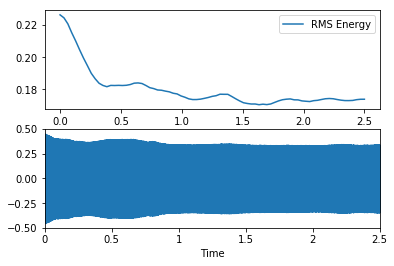

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

sig,sr=librosa.core.load(datapath + "/" + "reed_acoustic_000-072-127.wav", sr=None)
rmse=librosa.feature.rmse(y=sig)[0]
rmse_times = np.linspace(0.0,len(sig)/sr, len(rmse) )

plt.figure()
plt.subplot(2, 1, 1)
#plt.semilogy(rmse.T, label='RMS Energy')
plt.plot(rmse_times, rmse, label='RMS Energy')
plt.legend(loc='best')

plt.subplot(2, 1, 2)
librosa.display.waveplot(sig, sr=16000)

print('duration=',len(sig)/sr)

In [8]:
datafiles = [fname for fname in pm.getFullPathNames(datapath)]
#check all durations are the same
def check_duration(filelist):
    """use librosa's get_duration method to find the duration of all files in filelist"""
    filedurations = [librosa.core.get_duration(filename=f) for f in filelist]
    assert filedurations.count(filedurations[0]) == len(filedurations), "File durations are not all the same!"
    return filedurations[0]

duration = check_duration(datafiles) 
print(duration)

2.5


# paramManager - analyze data files to create a new parameter with LibRosa 

In [9]:
# Get a list of data file names so we can pass them to essentia for analysis
for fname in pm.getFullPathNames(datapath) :
    print("processing {}".format(fname))

    sig,sr=librosa.core.load(fname, sr=None)
    rmse=librosa.feature.rmse(y=sig)[0]
    rmse_times = np.linspace(0.0,len(sig)/sr, len(rmse) )
    
    # Now add the data to the parameter file
    ##-----------   paramManager  interface   ------------------##
    pm.addParam(fname, "rmse", rmse_times, rmse, units="energy", nvals=0, minval=0, maxval=None)
    

processing ../dataset/brass_acoustic_018-052-127.wav
processing ../dataset/brass_acoustic_018-053-127.wav
processing ../dataset/brass_acoustic_018-054-127.wav
processing ../dataset/brass_acoustic_018-055-127.wav
processing ../dataset/brass_acoustic_018-056-127.wav
processing ../dataset/brass_acoustic_018-057-127.wav
processing ../dataset/brass_acoustic_018-058-127.wav
processing ../dataset/brass_acoustic_018-059-127.wav
processing ../dataset/brass_acoustic_018-060-127.wav
processing ../dataset/brass_acoustic_018-061-127.wav
processing ../dataset/brass_acoustic_018-062-127.wav
processing ../dataset/brass_acoustic_018-063-127.wav
processing ../dataset/brass_acoustic_018-064-127.wav
processing ../dataset/brass_acoustic_018-065-127.wav
processing ../dataset/brass_acoustic_018-066-127.wav
processing ../dataset/brass_acoustic_018-067-127.wav
processing ../dataset/brass_acoustic_018-068-127.wav
processing ../dataset/brass_acoustic_018-069-127.wav
processing ../dataset/brass_acoustic_018-070-1

# paramManager, add params from info stored in filenames

In [10]:
import re

for fname in pm.getFullPathNames(datapath) :
    print("processing {}".format(fname))
    
    # first, instrument ID
    if fname.find("brass") >=0 : 
        instID=0
    else : 
        instID=1
    print("    {} is in category {}".format(fname, 1))
            
    ##-----------   paramManager  interface   ------------------##
    pm.addParam(fname, "instID", [0.0,duration], [instID,instID], units="category", nvals=2, minval=0, maxval=1)
    

    #now midiPitch
    n=re.findall(r'(?<=-).*?(?=-)', fname)[0] #3-digit pitch number wedged between dashes (-) in name
    if (n[0]=='0') :
        midinum=int(n[1:])
    else :
        midinum=int(n)
    print("    midi number is {}".format(midinum))
    
    ##-----------   paramManager  interface   ------------------##
    pm.addParam(fname, "midiPitch", [0.0,duration], [midinum,midinum], units="midiPitch", nvals=128, minval=0, maxval=127)
    

processing ../dataset/brass_acoustic_018-052-127.wav
    ../dataset/brass_acoustic_018-052-127.wav is in category 1
    midi number is 52
processing ../dataset/brass_acoustic_018-053-127.wav
    ../dataset/brass_acoustic_018-053-127.wav is in category 1
    midi number is 53
processing ../dataset/brass_acoustic_018-054-127.wav
    ../dataset/brass_acoustic_018-054-127.wav is in category 1
    midi number is 54
processing ../dataset/brass_acoustic_018-055-127.wav
    ../dataset/brass_acoustic_018-055-127.wav is in category 1
    midi number is 55
processing ../dataset/brass_acoustic_018-056-127.wav
    ../dataset/brass_acoustic_018-056-127.wav is in category 1
    midi number is 56
processing ../dataset/brass_acoustic_018-057-127.wav
    ../dataset/brass_acoustic_018-057-127.wav is in category 1
    midi number is 57
processing ../dataset/brass_acoustic_018-058-127.wav
    ../dataset/brass_acoustic_018-058-127.wav is in category 1
    midi number is 58
processing ../dataset/brass_acoust

    midi number is 71
processing ../dataset/reed_acoustic_000-072-127.wav
    ../dataset/reed_acoustic_000-072-127.wav is in category 1
    midi number is 72
processing ../dataset/reed_acoustic_000-073-127.wav
    ../dataset/reed_acoustic_000-073-127.wav is in category 1
    midi number is 73
processing ../dataset/reed_acoustic_000-074-127.wav
    ../dataset/reed_acoustic_000-074-127.wav is in category 1
    midi number is 74
processing ../dataset/reed_acoustic_000-075-127.wav
    ../dataset/reed_acoustic_000-075-127.wav is in category 1
    midi number is 75
processing ../dataset/reed_acoustic_000-076-127.wav
    ../dataset/reed_acoustic_000-076-127.wav is in category 1
    midi number is 76
processing ../dataset/reed_acoustic_000-077-127.wav
    ../dataset/reed_acoustic_000-077-127.wav is in category 1
    midi number is 77
processing ../dataset/reed_acoustic_000-078-127.wav
    ../dataset/reed_acoustic_000-078-127.wav is in category 1
    midi number is 78
processing ../dataset/reed

In [11]:

# Now lets have a look at one of our paramfiles
foo=pm.getParams(datapath + '/' + 'reed_acoustic_000-072-127.wav') #the path and extension are optional

{'meta': {'filename': 'reed_acoustic_000-072-127.wav'},
 'rmse': {'times': [0.0,
   0.03205128205128205,
   0.0641025641025641,
   0.09615384615384615,
   0.1282051282051282,
   0.16025641025641024,
   0.1923076923076923,
   0.22435897435897434,
   0.2564102564102564,
   0.28846153846153844,
   0.3205128205128205,
   0.35256410256410253,
   0.3846153846153846,
   0.41666666666666663,
   0.4487179487179487,
   0.4807692307692307,
   0.5128205128205128,
   0.5448717948717948,
   0.5769230769230769,
   0.6089743589743589,
   0.641025641025641,
   0.673076923076923,
   0.7051282051282051,
   0.7371794871794871,
   0.7692307692307692,
   0.8012820512820512,
   0.8333333333333333,
   0.8653846153846153,
   0.8974358974358974,
   0.9294871794871794,
   0.9615384615384615,
   0.9935897435897435,
   1.0256410256410255,
   1.0576923076923075,
   1.0897435897435896,
   1.1217948717948718,
   1.1538461538461537,
   1.1858974358974357,
   1.2179487179487178,
   1.25,
   1.282051282051282,
   1.3141

### resampling (interpolation) demo

In [12]:
#sometimes we need parameter values at a different sampling rate
#for example we have a section of data made up of 6 samples, taken from 0.0s to 0.03s of reed_acoustic_000-072-127.wav
#but there are only 2 rmse (parameter) values associated with this duration
#to get a rmse (parameter) for each of our 6 samples, load the parameter file using getParams then pass it to resampleParam as follows:

pm.resampleParam(foo,"rmse",6,0.0,0.03,verbose=True)

#this function uses scipy's linear interpolation method

--Data resampled from--
times: [0.0, 0.03205128205128205, 0.0641025641025641, 0.09615384615384615, 0.1282051282051282, 0.16025641025641024, 0.1923076923076923, 0.22435897435897434, 0.2564102564102564, 0.28846153846153844, 0.3205128205128205, 0.35256410256410253, 0.3846153846153846, 0.41666666666666663, 0.4487179487179487, 0.4807692307692307, 0.5128205128205128, 0.5448717948717948, 0.5769230769230769, 0.6089743589743589, 0.641025641025641, 0.673076923076923, 0.7051282051282051, 0.7371794871794871, 0.7692307692307692, 0.8012820512820512, 0.8333333333333333, 0.8653846153846153, 0.8974358974358974, 0.9294871794871794, 0.9615384615384615, 0.9935897435897435, 1.0256410256410255, 1.0576923076923075, 1.0897435897435896, 1.1217948717948718, 1.1538461538461537, 1.1858974358974357, 1.2179487179487178, 1.25, 1.282051282051282, 1.3141025641025639, 1.346153846153846, 1.3782051282051282, 1.4102564102564101, 1.442307692307692, 1.4743589743589742, 1.5064102564102564, 1.5384615384615383, 1.5705128205128

(array([0.   , 0.006, 0.012, 0.018, 0.024, 0.03 ]),
 array([0.22630847, 0.22596378, 0.2256191 , 0.22527442, 0.22492974,
        0.22458506]))

In [13]:
#the default behaviour of resampleParam is not to overwrite the original param file

foo=pm.getParams(datapath + '/' + 'reed_acoustic_000-072-127.wav')
foo

{'meta': {'filename': 'reed_acoustic_000-072-127.wav'},
 'rmse': {'times': [0.0,
   0.03205128205128205,
   0.0641025641025641,
   0.09615384615384615,
   0.1282051282051282,
   0.16025641025641024,
   0.1923076923076923,
   0.22435897435897434,
   0.2564102564102564,
   0.28846153846153844,
   0.3205128205128205,
   0.35256410256410253,
   0.3846153846153846,
   0.41666666666666663,
   0.4487179487179487,
   0.4807692307692307,
   0.5128205128205128,
   0.5448717948717948,
   0.5769230769230769,
   0.6089743589743589,
   0.641025641025641,
   0.673076923076923,
   0.7051282051282051,
   0.7371794871794871,
   0.7692307692307692,
   0.8012820512820512,
   0.8333333333333333,
   0.8653846153846153,
   0.8974358974358974,
   0.9294871794871794,
   0.9615384615384615,
   0.9935897435897435,
   1.0256410256410255,
   1.0576923076923075,
   1.0897435897435896,
   1.1217948717948718,
   1.1538461538461537,
   1.1858974358974357,
   1.2179487179487178,
   1.25,
   1.282051282051282,
   1.3141

In [ ]:
#but this can be changed if overwrite=True

pm.resampleParam(foo, "rmse",10,0.15,0.25,verbose=True,overwrite=True)
foo=pm.getParams(datapath + '/' + 'reed_acoustic_000-072-127.wav')
foo

In [14]:
#instead of resampling 1 parameter at a time, use resampleAllParams to automatically interpolate all of them (will ignore meta)

paramdict = pm.resampleAllParams(foo,5,1.1,1.2,verbose=True)

['meta', 'rmse', 'instID', 'midiPitch']
rmse
--Data resampled from--
times: [0.0, 0.03205128205128205, 0.0641025641025641, 0.09615384615384615, 0.1282051282051282, 0.16025641025641024, 0.1923076923076923, 0.22435897435897434, 0.2564102564102564, 0.28846153846153844, 0.3205128205128205, 0.35256410256410253, 0.3846153846153846, 0.41666666666666663, 0.4487179487179487, 0.4807692307692307, 0.5128205128205128, 0.5448717948717948, 0.5769230769230769, 0.6089743589743589, 0.641025641025641, 0.673076923076923, 0.7051282051282051, 0.7371794871794871, 0.7692307692307692, 0.8012820512820512, 0.8333333333333333, 0.8653846153846153, 0.8974358974358974, 0.9294871794871794, 0.9615384615384615, 0.9935897435897435, 1.0256410256410255, 1.0576923076923075, 1.0897435897435896, 1.1217948717948718, 1.1538461538461537, 1.1858974358974357, 1.2179487179487178, 1.25, 1.282051282051282, 1.3141025641025639, 1.346153846153846, 1.3782051282051282, 1.4102564102564101, 1.442307692307692, 1.4743589743589742, 1.50641025

In [15]:
#we can even select which parameters to resample using the prop variable 
paramdict = pm.resampleAllParams(foo,5,1.1,1.2,prop=['instID','midiPitch'],verbose=True)

instID
--Data resampled from--
times: [0.0, 2.5]
values: [1, 1]
--to--
times: [1.1   1.125 1.15  1.175 1.2  ]
values: [1. 1. 1. 1. 1.]
 
midiPitch
--Data resampled from--
times: [0.0, 2.5]
values: [72, 72]
--to--
times: [1.1   1.125 1.15  1.175 1.2  ]
values: [72. 72. 72. 72. 72.]
 
